In [18]:
%pylab inline

import os, glob, sys, time, datetime
import pandas as pd
import pandas.io.sql as pdsql
from pandas import DataFrame, Series
import math
import numpy as np
from numpy import NaN, Inf, arange, isscalar, asarray, array
import scipy as sp
from scipy import stats
from scipy.stats import norm

import talib as ta
from talib import MA_Type

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.font_manager as font_manager
import seaborn as sns

#맑은고딕체
sns.set(style="whitegrid", font="Malgun Gothic", font_scale=1.5)
matplotlib.rcParams['figure.figsize'] = [20, 10]
fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\malgun.TTF", size=15)

#나눔고딕체
# sns.set(style="whitegrid", font="NanumGothic", font_scale=1.5)
# matplotlib.rcParams['figure.figsize'] = [20, 10]
# fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\NanumGothic.TTF", size=15)

#새굴림체
# sns.set(style="whitegrid", font="New Gulim", font_scale=1.5)
# matplotlib.rcParams['figure.figsize'] = [20, 10]
# fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\NGULIM.TTF", size=15)

def comma_volume(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}K'.format(int(x/1000))
    return s

def comma_price(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}'.format(int(x))
    return s

def comma_percent(x, pos):  # formatter function takes tick label and tick position
    s = '{:+.2f}'.format(x)
    return s

major_date_formatter = dates.DateFormatter('%Y-%m-%d')
minor_date_formatter = dates.DateFormatter('%m')
price_formatter = ticker.FuncFormatter(comma_price)
volume_formatter = ticker.FuncFormatter(comma_volume)
percent_formatter = ticker.FuncFormatter(comma_percent)

sns.set(style="whitegrid", font="Malgun Gothic", font_scale=1.5)
matplotlib.rcParams['figure.figsize'] = [20, 10]
fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\malgun.TTF", size=15)

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, XGBModel
from xgboost import plot_importance, plot_tree

In [20]:
def XGBoost_Feature(model, df, X_columns, y_columns, performCV=True, printFeatureImportance=True, cv_folds=5):
    print(model)

    model.fit(df[X_columns], df[y_columns])
        
    df_predictions = model.predict(df[X_columns])
    try:
        df_predprob = model.predict_proba(df[X_columns])[:,1]
    except Exception as e:
        pass

    print ("\n모델 보고서")
    try:
        print ("정확도(Accuracy) : %.4g" % metrics.accuracy_score(df[y_columns].values, df_predictions))
    except Exception as e:
        pass

    try:
        print ("AUC 점수 (Train): %f" % metrics.roc_auc_score(df[y_columns].values, df_predprob))
    except Exception as e:
        pass

    if performCV:
        try:
            cv_score = cross_validation.cross_val_score(model, df[X_columns], df[y_columns], cv=cv_folds, scoring='roc_auc')
            print ("교차검증(CV) 점수 : 평균 - %.7g | 표준편차 - %.7g | 최소값 - %.7g | 최대값 - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        except Exception as e:
            pass
        
    try:
        if printFeatureImportance:
            fig, ax = plt.subplots(1, 1, sharex=True)
            feat_imp = pd.Series(model.feature_importances_, X_columns).sort_values(ascending=False)
            feat_imp.plot(ax=ax, kind='bar', title='특성(Feature) 중요도')
            ax.yaxis.set_major_formatter(percent_formatter)
            plt.ylabel('특성(Feature) 중요도 점수')
            plt.savefig('특성(Feature) 중요도.png')
            plt.show()
    except Exception as e:
        pass

def XGBoost_TuningTest(model, X, y, param_grid=None):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

* 일간 가격차를 이용하여 학습 *

In [21]:
# CSV로 저장되어 있는 증권사 HTS 주가 자료는 시간 역순이라, 이것을 바로잡는다.
df = pd.read_csv('kodex200.csv', encoding='cp949')
df = df.reindex(index=df.index[::-1])
df.reset_index(inplace=True)
df.set_index('일시', inplace=True)
df.drop(['index'], axis=1, inplace=True)

df.tail()

,시가,고가,저가,종가
일시,,,,
2018-07-11,29515,29635,29280,29560
2018-07-12,29615,29800,29500,29650
2018-07-13,29695,30040,29685,29945
2018-07-16,29975,30050,29825,29855
2018-07-17,29860,29925,29680,29820


In [23]:
X_COLUMNS = []

for i in range(1,6):
    df['P%d' % i] = df['종가'] - df['종가'].shift(i)
    X_COLUMNS.append('P%d' % i)

In [25]:
# df['수익률'] = (df['고가'].shift(-1) - df['시가'].shift(-1)) / df['시가'].shift(-1)
df['수익률'] = (df['종가'].shift(-1) - df['시가'].shift(-1)) / df['시가'].shift(-1)
df['y'] = df['수익률'].apply(lambda x: 1 if x > 0.003 else 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df.tail()

,시가,고가,저가,종가,P1,P2,P3,P4,P5,수익률,y
일시,,,,,,,,,,,
2018-07-09,29460,29785,29375,29690,220.0,430.0,360.0,275.0,315.0,-0.002684,0
2018-07-10,29810,29905,29710,29730,40.0,260.0,470.0,400.0,315.0,0.001525,0
2018-07-11,29515,29635,29280,29560,-170.0,-130.0,90.0,300.0,230.0,0.001182,0
2018-07-12,29615,29800,29500,29650,90.0,-80.0,-40.0,180.0,390.0,0.008419,1
2018-07-13,29695,30040,29685,29945,295.0,385.0,215.0,255.0,475.0,-0.004003,0


In [26]:
X_COLUMNS

['P1', 'P2', 'P3', 'P4', 'P5']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

모델 보고서
정확도(Accuracy) : 0.6783
AUC 점수 (Train): 0.732526
교차검증(CV) 점수 : 평균 - 0.5086074 | 표준편차 - 0.02626302 | 최소값 - 0.4684048 | 최대값 - 0.5332059


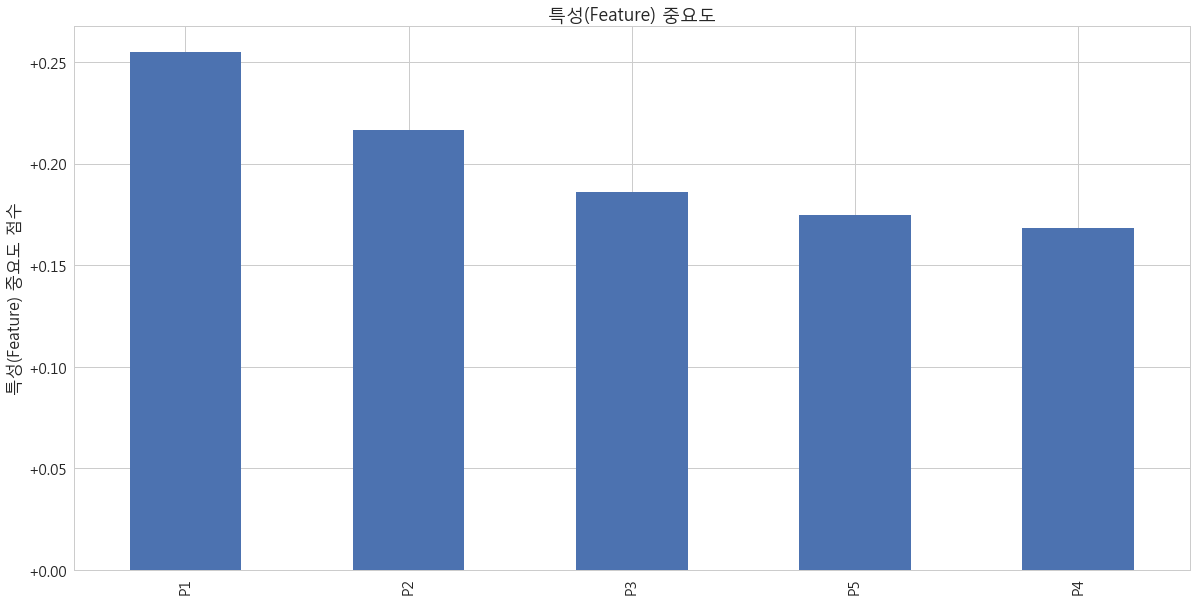

In [28]:
X = df[X_COLUMNS].values.tolist()
y = df['y'].values.tolist()

default_params = {'random_state': 0}
model = XGBClassifier(**default_params)

XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)


In [29]:
param_grid = {
    'max_depth': range(1, 4, 1),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1], 
    'n_estimators': range(10, 50, 10),
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'colsample_bylevel':[0.8, 1.0]
}

XGBoost_TuningTest(model, X=np.array(X), y=np.array(y), param_grid=param_grid)

Best: -0.645505 using {'colsample_bylevel': 0.8, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1, 'n_estimators': 30, 'max_depth': 3}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

모델 보고서
정확도(Accuracy) : 0.6498
AUC 점수 (Train): 0.569531
교차검증(CV) 점수 : 평균 - 0.5276278 | 표준편차 - 0.03778437 | 최소값 - 0.4803349 | 최대값 - 0.5820961


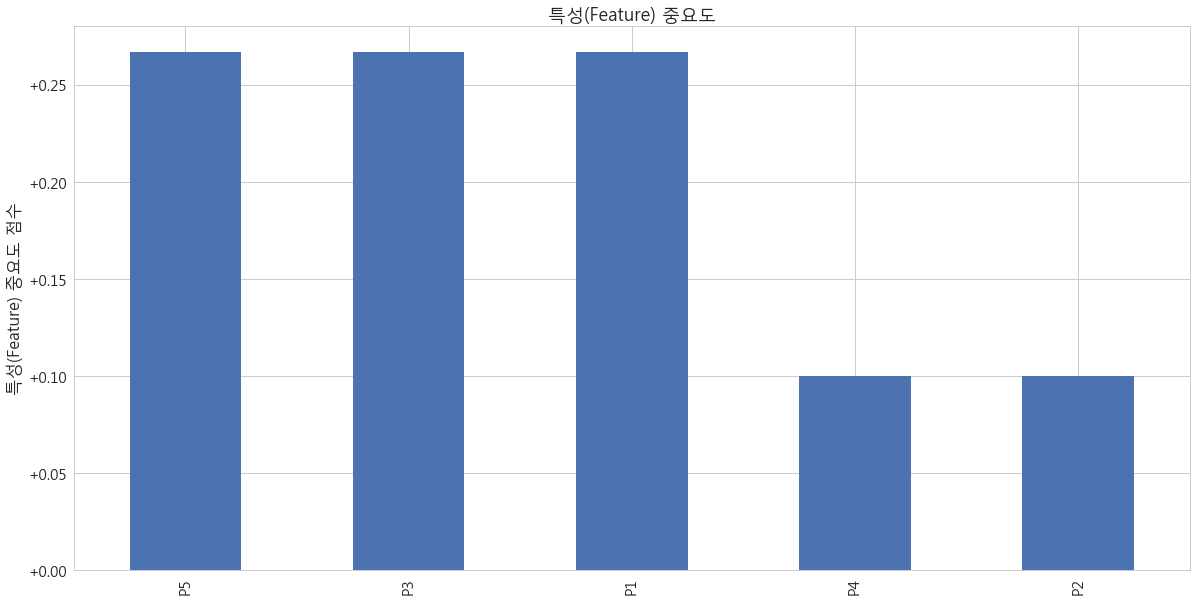

In [30]:
tuned_params = {'colsample_bylevel': 0.8, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 30, 'subsample': 0.8, 'random_state': 0}
model = XGBClassifier(**tuned_params)
XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)

* 기술적 지표를 이용

In [31]:
df = pd.read_csv('kodex200.csv', encoding='cp949')
df = df.reindex(index=df.index[::-1])
df.reset_index(inplace=True)
df.set_index('일시', inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.tail()

,시가,고가,저가,종가
일시,,,,
2018-07-11,29515,29635,29280,29560
2018-07-12,29615,29800,29500,29650
2018-07-13,29695,30040,29685,29945
2018-07-16,29975,30050,29825,29855
2018-07-17,29860,29925,29680,29820


In [32]:
X_COLUMNS = []

for i in [2,3,5,10,20,40,60,90,120,240]:
    df['EMA%03d' % i] = ta.EMA(np.array(df['종가'].astype(float)), timeperiod=i)
    df['이격도%03d' % i] = (df['종가'] - df['EMA%03d' % i]) / df['EMA%03d' % i]
    X_COLUMNS.append('이격도%03d' % i)

for i in [20, 60, 240]:
    df['Bup'], df['Bctr'], df['Bdown'] = ta.BBANDS(np.array(df['종가'].astype(float)), timeperiod=i, nbdevup=2.0, nbdevdn=2.0, matype=ta.MA_Type.EMA)
    df['pB%03d' % i] = (df['종가'] - df['Bdown']) / (df['Bup'] - df['Bdown'])
    X_COLUMNS.append('pB%03d' % i)

for i in [[5,3,3], [7,5,5], [10,6,6], [15,7,7], [20,10,10]]:
    df['slowk%03d%03d%03d' % (tuple(i))], df['slowd%03d%03d%03d' % (tuple(i))] = ta.STOCH(np.array(df['고가'].astype(float)), np.array(df['저가'].astype(float)),np.array(df['종가'].astype(float)), 
    fastk_period=i[0], slowk_period=i[1], slowk_matype=ta.MA_Type.EMA, slowd_period=i[2], slowd_matype=ta.MA_Type.EMA)
    X_COLUMNS.append('slowk%03d%03d%03d' % (tuple(i)))
    X_COLUMNS.append('slowd%03d%03d%03d' % (tuple(i)))

for i in [5,7,10,15,17,20]:
    df['LINEARREG%03d' % i] = ta.LINEARREG(np.array(df['종가'].astype(float)),timeperiod=i)
    X_COLUMNS.append('LINEARREG%03d' % i)

for i in [5,10,20,30,60]:
    df['TSF%03d' % i] = ta.TSF(np.array(df['종가'].astype(float)), timeperiod=i)
    X_COLUMNS.append('TSF%03d' % i)

for i in [3,5,7,10,14]:
    df['RSI%02d' % i] = ta.RSI(np.array(df['종가'].astype(float)), timeperiod=i) / 100
    X_COLUMNS.append('RSI%02d' % i)

for i in range(1,6):
    df['R%d' % i] = (df['종가']-df['종가'].shift(i)) / df['종가'].shift(i)
    X_COLUMNS.append('R%d' % i)
    
for i in range(1,6):
    df['P%d' % i] = (df['종가'] - df['종가'].rolling(window=5).min().shift(i)) / (df['종가'].rolling(window=5).max().shift(i) - df['종가'].rolling(window=5).min().shift(i))
    X_COLUMNS.append('P%d' % i)    

In [37]:
# df['수익률'] = (df['고가'].shift(-1) - df['시가'].shift(-1)) / df['시가'].shift(-1)
df['수익률'] = (df['종가'].shift(-1) - df['시가'].shift(-1)) / df['시가'].shift(-1)
df['y'] = df['수익률'].apply(lambda x: 1 if x > 0.003 else 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df.tail()

,시가,고가,저가,종가,EMA002,이격도002,EMA003,이격도003,EMA005,이격도005,...,R3,R4,R5,P1,P2,P3,P4,P5,수익률,y
일시,,,,,,,,,,,,,,,,,,,,,
2018-07-06,29250,29605,29130,29470,29413.241564,0.001930,29413.135815,0.001933,29483.368467,-0.000453,...,0.001870,0.003234,-0.019138,0.267516,0.195804,0.108571,0.096447,-1.228916,0.007807,1
2018-07-09,29460,29785,29375,29690,29597.747188,0.003117,29551.567908,0.004684,29552.245644,0.004661,...,0.012274,0.009349,0.010723,2.047619,0.547771,0.503497,0.360000,0.319797,-0.002684,0
2018-07-10,29810,29905,29710,29730,29685.915729,0.001485,29640.783954,0.003010,29611.497096,0.004002,...,0.016063,0.013638,0.010709,1.093023,2.238095,0.598726,0.559441,0.405714,0.001525,0
2018-07-11,29515,29635,29280,29560,29601.971910,-0.001418,29600.391977,-0.001365,29594.331398,-0.001160,...,0.003054,0.010253,0.007842,0.638298,0.697674,1.428571,0.382166,0.321678,0.001182,0
2018-07-12,29615,29800,29500,29650,29633.990637,0.000540,29625.195988,0.000837,29612.887598,0.001253,...,-0.001347,0.006108,0.013329,0.829787,0.829787,0.906977,1.857143,0.496815,0.008419,1


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

모델 보고서
정확도(Accuracy) : 0.7331
AUC 점수 (Train): 0.809186
교차검증(CV) 점수 : 평균 - 0.4044279 | 표준편차 - 0.1307802 | 최소값 - 0.2484292 | 최대값 - 0.5931589


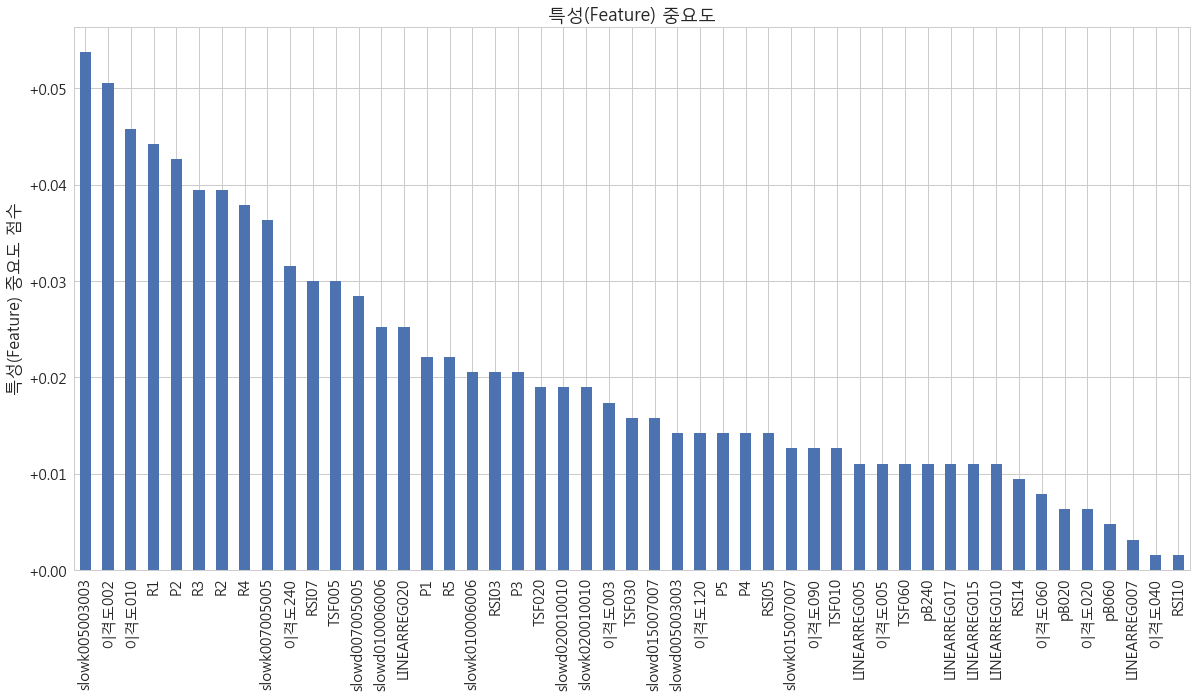

In [38]:
X = df[X_COLUMNS].values.tolist()
y = df['y'].values.tolist()

default_params = {'random_state': 0}
model = XGBClassifier(**default_params)

matplotlib.rcParams['figure.figsize'] = [20, 10]
XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)